### Normal Squares, toggleable features 
-   This code creates a series of squares around the all exterior contours of a cell, normal to its outline, that can then be extracted into images
-   second_pass and variable_length can be toggled for additional overlap accuracy and varying lenghts of squares, respectively
    - There is also now a score and grid search for optimization of coverage and minimization of excess blank pixels over the patching

### Basic Algorithm Outline:

-   Begin by extracting all external contours of a thresholded image
-   Then for every point along the contours, find a tangent point and use that to calculate the normal vector "into" the cell
-   Use these vectors and set square size or an iterative approach (variable_length=True/False) to find the length, from epithelium width, and corners of many squares along the contour
    - This is currenlty done by creating a square at every set step rate and checking these for overlap against each other
-   Overlapping squares are checked and removed, a second pass checks all remaining squares as the first checks only the last x created squares
-   The remaining squares are stored and drawn on the original image


-   There is also an evaluation score that checks total coverage of the epithelium and number of blank pixles in the created mask, which can be used to tune hyperparameters in a GrdiSearch
    - Further refined approaches to creation and selection may not require this step as the model is currently parameter sensitive


### Most Up-to_Date Features:
-   There are a few different initial square creation methods in development
    - Dense Squares creates many overlapping squares that are then filtered down to a mask of the image
    - Create smarter_sqaures creates a new square once the overlap threshold has been met
        - smarter_squares is slower but aims to depricate the remove_overlapping squares function and its hyperparameters

-   This algorithm currenlty just draws squares on the image, but the stored coordinates can be extracted to individual images

In [208]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds
image1=cv2.imread("h2114163 h&e_ROI_1 Epithelia.png")


image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# if using image of tissue slice epitheilum: 
_,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)

# if using mask annotation extract:
#_,whole_thresh=cv2.threshold(image1_gray,240,255,cv2.THRESH_BINARY_INV)



In [209]:
def find_external_contours(binary_image):
    '''find all external contours of an image'''

    contours,hierarchy=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #This can be used to alter the order contour points are processed in while maintaining order
        #Think [1,2,3,4,5]->[4,5,1,2,3]
        #Set to 0 for no effect, check np documentation for more info
    return [np.roll(contour,0,axis=0) for contour in contours]

def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        #Higher smoothingn values result in less "jutty" squares, but can work poorly on smaller regions of epithelium
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]

        # Anna new code
        # Ensure all normals point inward by calculating the contour's centroid
        moments = cv2.moments(contour)
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        
        # Check the direction of the normal at the first point (it should point towards the centroid)
        first_point = points[0]
        direction_to_centroid = np.array([cx - first_point[0], cy - first_point[1]])

        # If the normal is not pointing towards the centroid, flip the normals
        if np.dot(normals[0], direction_to_centroid) > 0:
            normals = -normals  # Flip the normals if they are pointing outward
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    #Loop to find variable length
    if variable_length:
        i=square_size
        while True:
            #Increase i while extending into cell
            test_point=point-(normal*i).astype(int)
            test_point=np.clip(test_point,0,np.array(binary_image.shape[:2])[::-1] - 1)

            #Break when non 1(cell) value
            if binary_image[test_point[1],test_point[0]]==0:
                break
            i+=10

        extended_length=i
        half_size=i//2

    corners=np.array([
        point+(tangent*half_size),
        point-(tangent*half_size),
        point-(tangent*half_size)-(normal*extended_length),
        point+(tangent*half_size)-(normal*extended_length)
    ])
    

    return corners,extended_length

def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,square_size=128,step=5,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares=[]


    #Loop over all contours 
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1,2)
        n_points=len(points)
        squares=[]

        #Find corners at step length
        for i in range(0, n_points, step): 
            corners,length=calculate_square_corners(points[i],contour_normals[i],square_size,binary_image,variable_length)

            if length>=750 or length<64: #Trying to avoid badly sized squares
                continue

            squares.append(corners)

        all_squares.append(squares)
    return all_squares



def create_smarter_squares(contours,normals,binary_image,square_size,overlap_thresh,variable_length=True):
    '''Create squares that meet overlap thresh with last square'''
    return_squares=[]


    #Loop over all contours and get corresponding normals to point
    for contour, contour_normals in zip(contours,normals):
        points=contour.reshape(-1,2)
        squares=[]
        last_square=None

        #Go over points, evaluating if next square's corner falls outside of range of last square
        for i,point in enumerate(points):
            corners,length=calculate_square_corners(point,contour_normals[i],square_size,binary_image,variable_length)

            #Prevent poorly sized squares
            if length>750 or length<75:
                continue
            
            #Check for last square overlapping with first, not checked by default
            elif (i==len(points)-1) and (calculate_square_overlap(corners,squares[0])<=overlap_thresh) and (calculate_square_overlap(corners,last_square)<=overlap_thresh):
                    last_square=corners
                    squares.append(corners)
                    continue
            
            #Check current against last square
            elif calculate_square_overlap(last_square,corners)<=overlap_thresh:
                    last_square=corners
                    squares.append(corners)
                    continue

            else:
                continue
        return_squares.append(squares)
    return return_squares

def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[1]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened=[square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list=[]

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares=[]

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found=False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap=calculate_square_overlap(square, other_square)
                        if overlap>overlap_thresh:
                            overlap_found=True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result



def process_contours(image,binary_image,square_size=128,step=5,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        square_size (int): Base size of squares
        step (int): Points to skip between squares
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_external_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    normals=calculate_contour_normals(contours,smoothing_size)

    #squares_list=create_smarter_squares(contours,normals,binary_image,overlap_thresh=overlap_thresh,square_size=square_size,variable_length=variable_length)
    squares_list=create_dense_squares(contours,normals,whole_thresh,square_size=square_size,step=step,variable_length=variable_length)
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )    
    result = draw_squares(image,final_squares_list)
    
    return result, contours, final_squares_list, normals





In [210]:
def check_metrics(binary_image,contours):
    '''Evaluate fit of normal squares using mask'''

    total_white_pixels=(binary_image>0).sum()
    squares_mask=np.zeros_like(binary_image,dtype=np.uint8)

    weight_coverage=0.8
    weight_black_pixels=0.2
    
    #For all squares in all contours, use them to create a mask
    for contour in contours:
        for square in contour:
            square=np.array(square,dtype=np.int32).reshape(-1,1,2)
            cv2.fillPoly(squares_mask,[square],255)

    mask_pixels=np.count_nonzero(squares_mask>0)

    #Find coverage and non-epitheliuem pixel values 

    covered_white_pixels=np.count_nonzero((squares_mask>0)&(binary_image>0))
    covered_black_pixels=np.count_nonzero((squares_mask>0)&(binary_image==0))

    total_coverage=(covered_white_pixels/total_white_pixels*100)
    black_pixel_percent=(covered_black_pixels/mask_pixels*100)
    score=weight_coverage*total_coverage+weight_black_pixels*(100-black_pixel_percent)
    
    return total_coverage,black_pixel_percent,score
        


In [211]:
def search_params(param_grid,binary_image,image,overlap_thresh=0.05):
    '''
    Grid Search to find best parameters for normal squares
    Runs the algorithm many times and stores best result and corresponding params
    '''
    best_params=[]
    best_result=None

    for params in param_grid:
        square_size=params['square_size']
        step=params['step']
        smoothing_size=params['smoothing_size']
        look_back=params['look_back']

        _,_,squares_test=process_contours(image,binary_image,square_size,step,overlap_thresh=0,
                                          smoothing_size=smoothing_size,look_back=look_back,second_pass=True, variable_length=True)

        coverage,black_percent,score=check_metrics(binary_image,squares_test)

        if best_result is None or score>best_result[2]:
            best_result=(coverage,black_percent,score)
            best_params=params

    step=best_params['step']
    look_back=best_params['look_back']

    result_image,best_contours,best_squares=process_contours(image,binary_image,square_size=best_params['square_size'],
                                                step=best_params['step'],overlap_thresh=overlap_thresh,smoothing_size=best_params['smoothing_size'],
                                                look_back=best_params['look_back'],second_pass=True,variable_length=True)
    print(f"Best Parameters: {best_params}")
    print(f"Best Total Coverage: {best_result[0]:.2f}%")
    print(f"Best Black Pixel Percentage: {best_result[1]:.2f}%")
    print(f"Best Score Percentage: {best_result[2]:.2f}%")

    plt.imshow(result_image)
    return result_image,best_contours,best_squares

param_grid=ParameterGrid({'square_size':[4],'look_back':[8,18,30,50,70],'step':[3,8,30,50,72],'smoothing_size':[150,30,100,120,200]})
search_params(param_grid,whole_thresh,image1,overlap_thresh=0.07);

Coverage: 74.86%, Percent of mask as blank pixels: 16.30%, Score: 76.63%


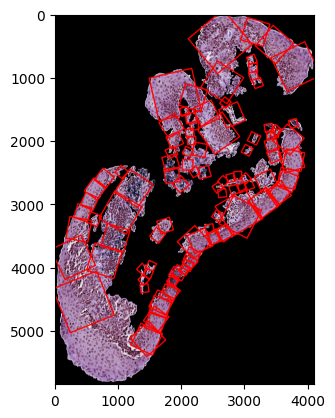

In [212]:
result_image, contour, squares, normals = process_contours(
     image1,
     whole_thresh,
     square_size=128,
     step=5,
     overlap_thresh=0.1,
     smoothing_size=210,
     look_back=8,
     second_pass=False,
     variable_length=True)

plt.imshow(result_image)

coverage,perc_black_pixels,score=check_metrics(whole_thresh,squares)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')

In [213]:
import matplotlib.pyplot as plt

def visualize_normals(image, contours, normals):
    plt.imshow(image, cmap='gray')

    for contour, normal in zip(contours, normals):
        points = contour.reshape(-1, 2)
        for i in range(0, len(points), 10):  # Sample every 10 points
            p = points[i]
            n = normal[i] * 50  # Scale for visibility
            plt.arrow(p[0], p[1], n[0], n[1], color='red', head_width=3)

    plt.show()


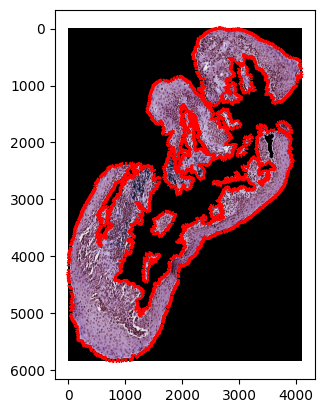

In [214]:
visualize_normals(image1, contour, normals)